In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
%matplotlib inline

/home/sujit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DATA_DIR = "../../data"

MOVIE_FILE = os.path.join(DATA_DIR, "movies.csv")
RATINGS_FILE = os.path.join(DATA_DIR, "ratings.csv")

RESULTS_FILE = os.path.join(DATA_DIR, "eval_results.csv")
CONSOLE_FILE = os.path.join(DATA_DIR, "eval_console.txt")

## Extract Data into Sparse Matrix

In [3]:
movies_df = pd.read_csv(MOVIE_FILE)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies_id2name, movies_name2id = {}, {}
ids = movies_df["movieId"].values
titles = movies_df["title"].values
for id, title in zip(ids, titles):
    movies_id2name[id] = title
    movies_name2id[title] = id

In [5]:
ratings_df = pd.read_csv(RATINGS_FILE)
ratings_df.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [6]:
movies_id2idx, movies_idx2id = {}, {}
for idx, movie_id in enumerate(ratings_df["movieId"].unique()):
    movies_id2idx[movie_id] = idx
    movies_idx2id[idx] = movie_id

In [7]:
users_id2idx, users_idx2id = {}, {}
for idx, user_id in enumerate(ratings_df["userId"].unique()):
    users_id2idx[user_id] = idx
    users_idx2id[idx] = user_id

In [8]:
num_users = len(users_id2idx)
num_movies = len(movies_id2idx)
print(num_users, num_movies)

862 2500


In [9]:
def construct_original_matrix(num_users, num_movies, ratings_df, 
                          users_id2idx, movies_id2idx):
    X = np.zeros((num_users, num_movies), dtype=np.float32)
    for user_id, movie_id, rating in ratings_df[["userId", "movieId", "rating"]].values:
        X[users_id2idx[user_id], movies_id2idx[movie_id]] = rating
    return X

R_val = construct_original_matrix(num_users, num_movies, ratings_df,
                                  users_id2idx, movies_id2idx)
print(R_val.shape)

(862, 2500)


## Compute bias and remove

In [10]:
def compute_bias(X, bias_type):
    Xc = X.copy()
    Xc[Xc == 0] = np.nan
    if bias_type == "global":
        return np.nanmean(Xc)
    elif bias_type == "user":
        return np.mean(np.nanmean(Xc, axis=0))
    elif bias_type == "item":
        return np.mean(np.nanmean(Xc, axis=1))
    else:
        raise Exception("invalid bias type, can only be one of global, user and item")


def remove_bias(X, bias):
    Xc = X.copy()
    Xc[Xc == 0] = np.nan
    Xc = np.subtract(Xc, bias)
    Xc = np.nan_to_num(Xc)
    return Xc

        
bg = compute_bias(R_val, "global")
Rg_val = remove_bias(R_val, bg)

bu = compute_bias(Rg_val, "user")
Ru_val = remove_bias(Rg_val, bu)

bi = compute_bias(Rg_val, "item")
Ri_val = remove_bias(Rg_val, bi)

bui = compute_bias(Ru_val, "item")
Rui_val = remove_bias(Ru_val, bui)

print("   global bias: {:.3f}".format(bg))
print("     user bias: {:.3f}".format(bu))
print("     item bias: {:.3f}".format(bi))
print("user-item bias: {:.3f}".format(bui))
print("")
print("before bias removal:\n", R_val[0:1, 0:5], "...")
print("after user bias removal:\n", Ru_val[0:1, 0:5], "...")
print("after item bias removal:\n", Ri_val[0:1, 0:5], "...")
print("after user-item bias removal:\n", Rui_val[0:1, 0:5], "...")

   global bias: 3.504
     user bias: -0.138
     item bias: 0.127
user-item bias: 0.265

before bias removal:
 [[4.  3.5 5.  5.  4.5]] ...
after user bias removal:
 [[0.63425964 0.13425966 1.6342597  1.6342597  1.1342597 ]] ...
after item bias removal:
 [[ 0.36936247 -0.13063753  1.3693625   1.3693625   0.8693625 ]] ...
after user-item bias removal:
 [[ 0.3693624  -0.13063757  1.3693625   1.3693625   0.8693625 ]] ...


## Reduce dimensions

In [11]:
def reconstruct_using_svd(X, k):
    
    if k == 0:
        return X, 1., 0.
    
    graph = tf.Graph()
    with graph.as_default():
        
        # input arg
        R = tf.placeholder(tf.float32, shape=(num_users, num_movies), name="R")
        
        # run SVD
        S, U, Vt = tf.svd(R, full_matrices=True)
        
        # reduce dimensions
        Sk = tf.diag(S)[0:k, 0:k]
        Uk = U[:, 0:k]
        Vk = tf.transpose(Vt)[0:k, :]

        # reconstruct matrix
#         Rprime = tf.matmul(tf.matmul(Uk, Sk), Vk)
        Rprime = tf.matmul(Uk, tf.matmul(Sk, Vk))

        
        # compute reconstruction RMSE
        rsquared = tf.linalg.norm(Rprime) / tf.linalg.norm(R)
        rmse = tf.metrics.root_mean_squared_error(R, Rprime)[1]
        
    with tf.Session(graph=graph) as sess:
        
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        
        [Rprime_val, rsquared_val, rmse_val] = sess.run(
            [Rprime, rsquared, rmse], feed_dict={R: X})
        return Rprime_val, rsquared_val, rmse_val


R_rec, rsquared, rec_err = reconstruct_using_svd(R_val, 10)

print("reconstruction error (RMSE):", rec_err)
print("percentage of variance explained: {:.3f}".format(rsquared))
print("shape of reconstructed matrix: ", R_rec.shape)

reconstruction error (RMSE): 0.911226
percentage of variance explained: 0.700
shape of reconstructed matrix:  (862, 2500)


## Predict and Recommend

In [12]:
def predict(user_id, movie_ids, X_rec, bias, 
            users_id2idx, movies_id2idx, movies_id2name):
    predictions = []
    for movie_id in sorted(movie_ids):
        user_idx = users_id2idx[user_id]
        movie_idx = movies_id2idx[movie_id]
        movie_name = movies_id2name[movie_id]
        prediction = bias + X_rec[user_idx, movie_idx]
        predictions.append((user_id, movie_id, movie_name, prediction))
    return predictions


def recommend(user_id, X_rec, top_n, bias, 
              users_id2idx, movies_idx2id, movies_id2name):
    user_idx = users_id2idx[user_id]
    rec_movies_idxs = np.argsort(-1 * X_rec[user_idx])[0:top_n]
    recommendations = []
    for movie_idx in rec_movies_idxs:
        movie_id = movies_idx2id[movie_idx]
        movie_name = movies_id2name[movie_id]
        pred_rating = bias + X_rec[user_idx, movie_idx]
        recommendations.append((user_id, movie_id, movie_name, pred_rating))
    return recommendations


R_rec, _, _ = reconstruct_using_svd(Rui_val, 50)
preds = predict(320, [260, 153, 527, 588], R_rec, bg + bu + bui, users_id2idx, 
                movies_id2idx, movies_id2name)
for pred in preds:
    print(pred)
print("---")
R_rec, _, _ = reconstruct_using_svd(Ri_val, 50)
recs = recommend(320, R_rec, 10, bg + bi, users_id2idx, movies_idx2id, movies_id2name)
for rec in recs:
    print(rec)

(320, 153, 'Batman Forever (1995)', 3.5883482)
(320, 260, 'Star Wars: Episode IV - A New Hope (1977)', 4.031598)
(320, 527, "Schindler's List (1993)", 3.769835)
(320, 588, 'Aladdin (1992)', 3.5995538)
---
(320, 2571, 'Matrix, The (1999)', 4.281472)
(320, 2959, 'Fight Club (1999)', 4.2387533)
(320, 4993, 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 4.0973997)
(320, 296, 'Pulp Fiction (1994)', 4.089973)
(320, 1196, 'Star Wars: Episode V - The Empire Strikes Back (1980)', 4.0807734)
(320, 1136, 'Monty Python and the Holy Grail (1975)', 4.055152)
(320, 5952, 'Lord of the Rings: The Two Towers, The (2002)', 4.0527725)
(320, 7153, 'Lord of the Rings: The Return of the King, The (2003)', 4.0478134)
(320, 260, 'Star Wars: Episode IV - A New Hope (1977)', 4.031599)
(320, 4973, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 4.020437)


## Evaluate

In [13]:
def print_console(fconsole, X, k, bias_model, bias,
                  users_id2idx, movies_id2idx, movies_idx2id, 
                  movies_id2name):
    fconsole.write("#### predict -PuserId=320 -PitemIds=260,153,527,588 -PbiasModel={:s} -PfeatureCount={:d}\n"
                   .format(bias_model, k))
    predictions = predict(320, [260, 153, 527, 588], X, bias, 
                          users_id2idx, movies_id2idx, movies_id2name)
    for user_id, movie_id, movie_name, prediction in predictions:
        fconsole.write("\t{:d}\t{:d}\t{:s}\t{:.3f}\n"
            .format(user_id, movie_id, movie_name, prediction))
    fconsole.write("#### recommend -PuserId=320 -PbiasModel={:s} -PfeatureCount={:d}\n"
                   .format(bias_model, k))
    recommendations = recommend(320, X, 10, bias, users_id2idx, 
                                movies_idx2id, movies_id2name)
    for user_id, movie_id, movie_name, pred_rating in recommendations:
        fconsole.write("\t{:d}\t{:d}\t{:s}\t{:.3f}\n"
            .format(user_id, movie_id, movie_name, pred_rating))
    fconsole.write("\n")


kvalues = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50]
bias_models = ["none", "global", "user", "item", "user-item"]

fresults = open(RESULTS_FILE, "w")
fconsole = open(CONSOLE_FILE, "w")
for k in kvalues:
    print("running evaluation for k={:d}".format(k))
    # reconstruct original matrix
    R_val = np.zeros((num_users, num_movies), dtype=np.float32)
    for user_id, movie_id, rating in ratings_df[["userId", "movieId", "rating"]].values:
        R_val[users_id2idx[user_id], movies_id2idx[movie_id]] = rating
    # no bias
    bias_model = bias_models[0]
    R_rec, rsquared, rmse = reconstruct_using_svd(R_val, k)
    print(".. k={:d}, bias-model={:s}, reconstruction: R^2={:.3f}, RMSE={:.3f}"
          .format(k, bias_model, rsquared, rmse))
    fresults.write("{:d}\t{:s}\t{:.7f}\t{:.7f}\n".format(k, bias_model, rsquared, rmse))
    print_console(fconsole, R_rec, k, bias_model, 0, users_id2idx, 
                  movies_id2idx, movies_idx2id, movies_id2name)
    # global bias
    bias_model = bias_models[1]
    bg = compute_bias(R_val, bias_model)
    Rg_val = remove_bias(R_val, bg)
    R_rec, rsquared, rmse = reconstruct_using_svd(Rg_val, k)
    print(".. k={:d}, bias-model={:s}, reconstruction: R^2={:.3f}, RMSE={:.3f}"
          .format(k, bias_model, rsquared, rmse))
    fresults.write("{:d}\t{:s}\t{:.7f}\t{:.7f}\n".format(k, bias_model, rsquared, rmse))
    print_console(fconsole, R_rec, k, bias_model, bg, users_id2idx, 
                  movies_id2idx, movies_idx2id, movies_id2name)
    # global + user bias
    bias_model = bias_models[2]
    bu = compute_bias(Rg_val, bias_model)
    Ru_val = remove_bias(Rg_val, bu)
    R_rec, rsquared, rmse = reconstruct_using_svd(Ru_val, k)
    print(".. k={:d}, bias-model={:s}, reconstruction: R^2={:.3f}, RMSE={:.3f}"
          .format(k, bias_model, rsquared, rmse))
    fresults.write("{:d}\t{:s}\t{:.7f}\t{:.7f}\n".format(k, bias_model, rsquared, rmse))
    print_console(fconsole, R_rec, k, bias_model, bg + bu, users_id2idx, 
                  movies_id2idx, movies_idx2id, movies_id2name)
    # global + item bias
    bias_model = bias_models[3]
    bi = compute_bias(Rg_val, bias_model)
    Ri_val = remove_bias(Rg_val, bi)
    R_rec, rsquared, rmse = reconstruct_using_svd(Ri_val, k)
    print(".. k={:d}, bias-model={:s}, reconstruction: R^2={:.3f}, RMSE={:.3f}"
          .format(k, bias_model, rsquared, rmse))
    fresults.write("{:d}\t{:s}\t{:.7f}\t{:.7f}\n".format(k, bias_model, rsquared, rmse))
    print_console(fconsole, R_rec, k, bias_model, bg + bi, users_id2idx, 
                  movies_id2idx, movies_idx2id, movies_id2name)
    # global + user bias + item bias (user-item)
    bias_model = bias_models[4]
    bui = compute_bias(Ru_val, "item")
    Rui_val = remove_bias(Ru_val, bui)
    R_rec, rsquared, rmse = reconstruct_using_svd(Rui_val, k)
    print(".. k={:d}, bias-model={:s}, reconstruction: R^2={:.3f}, RMSE={:.3f}"
          .format(k, bias_model, rsquared, rmse))
    fresults.write("{:d}\t{:s}\t{:.7f}\t{:.7f}\n".format(k, bias_model, rsquared, rmse))
    print_console(fconsole, R_rec, k, bias_model, bg + bu + bui, users_id2idx, 
                  movies_id2idx, movies_idx2id, movies_id2name)

fresults.close()
fconsole.close()

running evaluation for k=0
.. k=0, bias-model=none, reconstruction: R^2=1.000, RMSE=0.000
.. k=0, bias-model=global, reconstruction: R^2=1.000, RMSE=0.000
.. k=0, bias-model=user, reconstruction: R^2=1.000, RMSE=0.000
.. k=0, bias-model=item, reconstruction: R^2=1.000, RMSE=0.000
.. k=0, bias-model=user-item, reconstruction: R^2=1.000, RMSE=0.000
running evaluation for k=1
.. k=1, bias-model=none, reconstruction: R^2=0.592, RMSE=1.028
.. k=1, bias-model=global, reconstruction: R^2=0.285, RMSE=0.334
.. k=1, bias-model=user, reconstruction: R^2=0.314, RMSE=0.334
.. k=1, bias-model=item, reconstruction: R^2=0.305, RMSE=0.334
.. k=1, bias-model=user-item, reconstruction: R^2=0.305, RMSE=0.334
running evaluation for k=5
.. k=5, bias-model=none, reconstruction: R^2=0.664, RMSE=0.954
.. k=5, bias-model=global, reconstruction: R^2=0.431, RMSE=0.314
.. k=5, bias-model=user, reconstruction: R^2=0.444, RMSE=0.315
.. k=5, bias-model=item, reconstruction: R^2=0.430, RMSE=0.317
.. k=5, bias-model=us

## Visualize Reconstruction RMSE vs target dimension

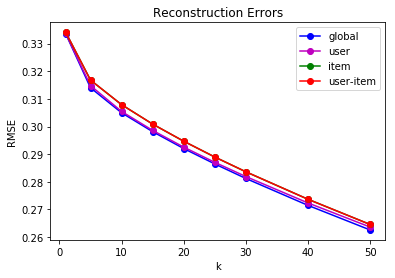

In [21]:
colors = ["c", "b", "m", "g", "r"]

# plt.figure(figsize=(10, 10))
plt.title("Reconstruction Errors")
plt.ylabel("RMSE")
plt.xlabel("k")
for i, bias_model in enumerate(bias_models):
    if bias_model == "none":
        continue
    xs, ys_rsquared, ys_rmse = [], [], []
    fresults = open(RESULTS_FILE, "r")
    for line in fresults:
        k, b, rsquared, rmse = line.strip().split("\t")
        k = int(k)
        rmse = float(rmse)
        rsquared = float(rsquared)
        if k == 0:
            continue
        if b == bias_model and k in kvalues:
            xs.append(k)
            ys_rsquared.append(rsquared)
            ys_rmse.append(rmse)
    fresults.close()
    plt.plot(xs, ys_rmse, marker="o", color=colors[i], label=bias_model)

p = plt.legend(loc="best")

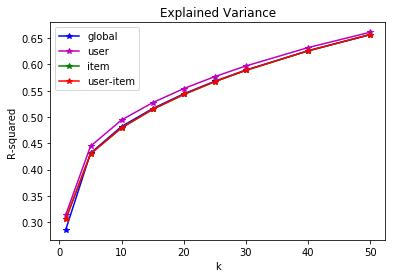

In [19]:
colors = ["c", "b", "m", "g", "r"]

# plt.figure(figsize=(10, 10))
plt.title("Explained Variance")
plt.ylabel("R-squared")
plt.xlabel("k")
for i, bias_model in enumerate(bias_models):
    if bias_model == "none":
        continue
    xs, ys_rsquared, ys_rmse = [], [], []
    fresults = open(RESULTS_FILE, "r")
    for line in fresults:
        k, b, rsquared, rmse = line.strip().split("\t")
        k = int(k)
        rmse = float(rmse)
        rsquared = float(rsquared)
        if k == 0:
            continue
        if b == bias_model and k in kvalues:
            xs.append(k)
            ys_rsquared.append(rsquared)
            ys_rmse.append(rmse)
    fresults.close()
    plt.plot(xs, ys_rsquared, marker="*", color=colors[i], label=bias_model)

p = plt.legend(loc="best")